In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage
from scipy import signal
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb

%matplotlib inline

In [2]:
def derivatives(img, method='ndi'):
    assert(method in {'conv', 'ndi', 'opencv'})
    if method == 'conv':
        sobel_filter_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
        img_dx = signal.convolve2d(img, sobel_filter_x, mode='same')
        sobel_filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        img_dy = signal.convolve2d(img, sobel_filter_y, mode='same')
    elif method == 'ndi':
        img_dx = ndimage.sobel(img, axis=1)
        img_dy = ndimage.sobel(img, axis=0)
    elif method == 'opencv':
        img_dx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        img_dy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    return img_dx, img_dy

In [3]:
def get_response(img, use_gaussian=True, sigma=1, window_size=5, use_k=True, k=0.05):
    img_dx, img_dy = derivatives(img)
    
    Ixx = img_dx * img_dx
    Ixy = img_dx * img_dy
    Iyy = img_dy * img_dy
    
    Mxx = np.zeros_like(img)
    Mxy = np.zeros_like(img)
    Myy = np.zeros_like(img)
    
    (m, n) = img.shape

    # Here comes the window
    if use_gaussian:
        Mxx = ndimage.gaussian_filter(Ixx, sigma)
        Mxy = ndimage.gaussian_filter(Ixy, sigma)
        Myy = ndimage.gaussian_filter(Iyy, sigma)
    else:
        assert(window_size % 2 == 1)
        assert(3 <= window_size <= 9)
        half = (window_size - 1) // 2
        
        for i in range(m): 
            for j in range(n): 
                i_start = max(0, i - half)
                i_end = min(m, i + half + 1)
                j_start = max(0, j - half)
                j_end = min(n, j + half + 1)
                Mxx[i, j] = Ixx[i_start: i_end, j_start: j_end].sum()
                Mxy[i, j] = Ixy[i_start: i_end, j_start: j_end].sum()
                Myy[i, j] = Iyy[i_start: i_end, j_start: j_end].sum()

    det = Mxx*Myy - Mxy*Mxy  
    trace = Mxx + Myy   
    if use_k:     
        response = det - k * trace**2
    else:
        response = 2 * det / (trace + 1e-6)
    return response


def plot_result(img, response, coords, title):
    def show_image(_img, ax, gray=False):
        if gray:
            ax.imshow(_img, cmap='gray', interpolation='bicubic')
        else:
            ax.imshow(_img, interpolation='bicubic')
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'xticks': [], 'yticks': []})
    plt.suptitle(title)
    show_image(response, ax[0], gray=True)
    show_image(img, ax[1])
    ax[1].plot(coords[:, 1], coords[:, 0], '.r', markersize=4)
    plt.show()


def my_harris(img, thresh, use_gaussian=True, sigma=1, window_size=5, use_k=True, k=0.05):
    img_gray = rgb2gray(img)
    if np.max(img_gray) > 1:
        img_gray = img_gray / 255
    response = get_response(img_gray, use_gaussian, sigma, window_size, use_k, k)
    coords = np.argwhere(response > thresh)
    plot_result(img, response, coords, 'My Algorithm')


def sk_harris(img):
    from skimage.feature import corner_harris, corner_peaks
    img_gray = rgb2gray(img)
    if np.max(img_gray) > 1:
        img_gray = img_gray / 255
    response = corner_harris(img_gray)
    coords = corner_peaks(response, min_distance=5)
    plot_result(img, response, coords, 'Scikit-image Algorithm')

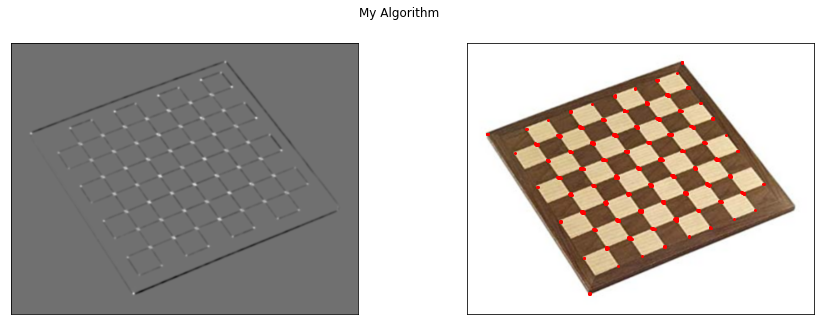

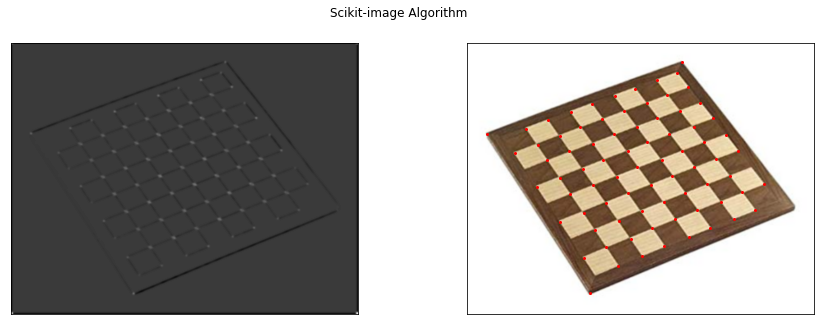

In [5]:
# Available images: chess.png, furniture.jpg, building.jpeg, richelieu.jpg
img = imread('images/chess.jpg')
my_harris(img, 1)
sk_harris(img)